In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
N_CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
            directory = './Dataset',
            image_size = (IMG_SIZE, IMG_SIZE),
            batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)  # 68 as 2152 images have been divided into batches of 32

68

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for img_batch, label_batch in dataset.take(1):    # take(n) returns n batches
    print('SHAPE OF IMAGE BATCH:', img_batch.shape)
    print('SHAPE OF THE FIRST IMAGE:', img_batch[0].shape)
    print('LABELS OF THE IMAGE BATCH:', label_batch.numpy())
    print('LABEL OF THE FIRST IMAGE:', class_names[label_batch[0]])

SHAPE OF IMAGE BATCH: (32, 256, 256, 3)
SHAPE OF THE FIRST IMAGE: (256, 256, 3)
LABELS OF THE IMAGE BATCH: [1 1 1 0 0 0 0 0 0 1 1 0 1 2 0 0 0 1 1 0 1 0 1 0 2 1 0 1 1 0 1 0]
LABEL OF THE FIRST IMAGE: Potato___Late_blight


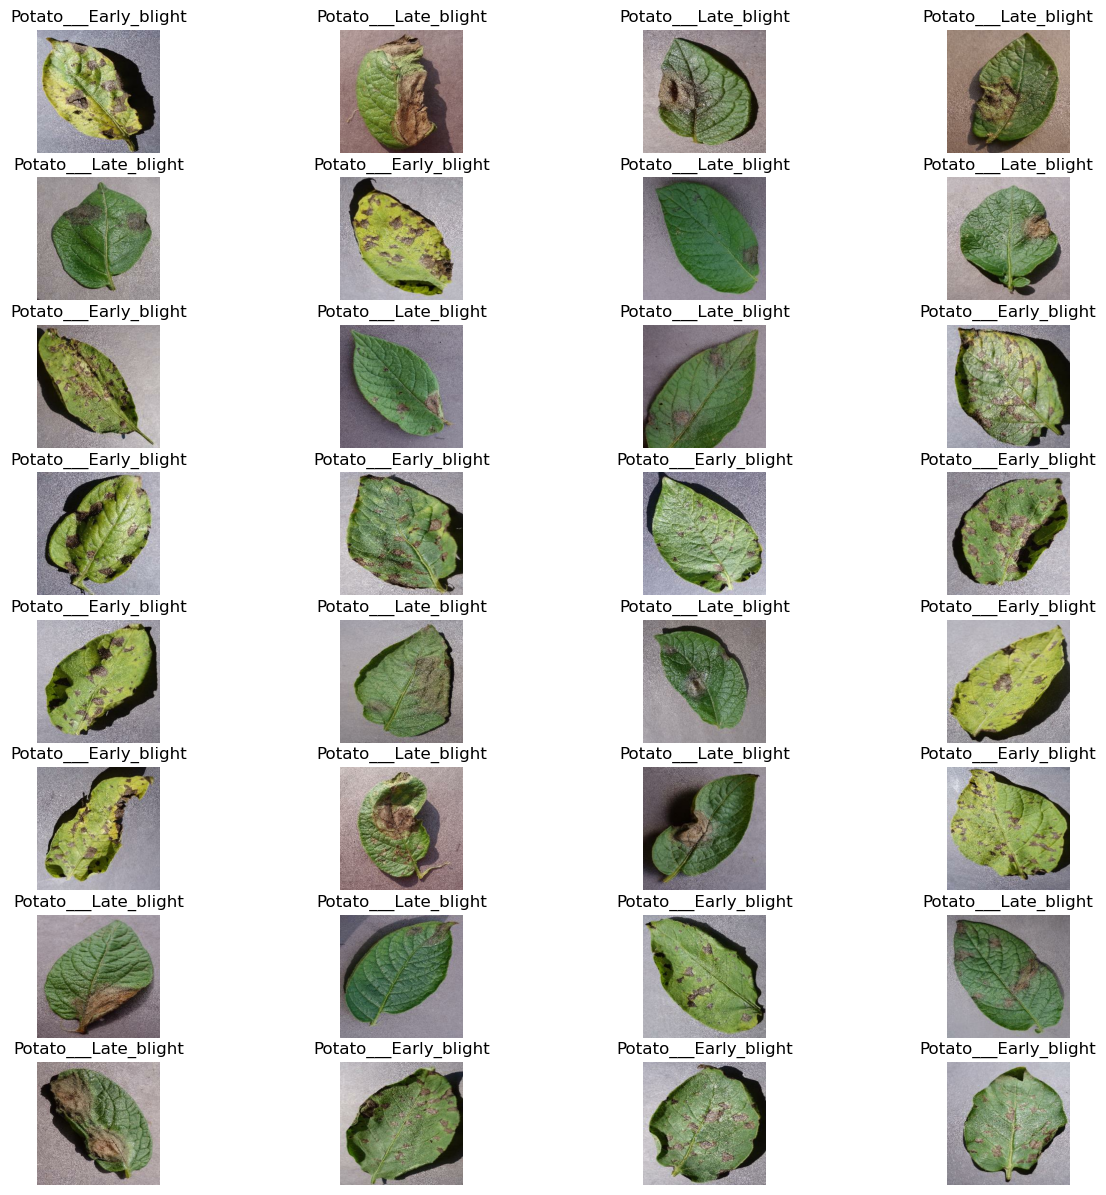

In [7]:
plt.figure(figsize=(15, 15))
for img_batch, label_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))         # Converting tensors to numpy array then to type integer
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def train_val_dev_split(dataset, train_split=0.8, val_split=0.1, dev_split=0.1, shuffle=True, shuffle_size = 10000):
    if shuffle:
        dataset.shuffle(buffer_size = shuffle_size, seed=12)
        
    data_size = len(dataset)
    train_size = int(data_size*train_split)
    val_size = int(data_size*val_split)
    
    df_train = dataset.take(train_size)
    df_val = dataset.skip(train_size).take(val_size)
    df_dev = dataset.skip(train_size).skip(val_size)

    return df_train, df_val, df_dev    

In [9]:
df_train, df_val, df_dev = train_val_dev_split(dataset)
print(f'SIZE OF TRAIN, VALIDATION AND DEV DATASETS ARE {len(df_train)}, {len(df_val)} AND {len(df_dev)} RESPECTIVELY')

SIZE OF TRAIN, VALIDATION AND DEV DATASETS ARE 54, 6 AND 8 RESPECTIVELY


#### Check out https://www.tensorflow.org/api_docs/python/tf/data/Dataset methods for the next cell

In [10]:
train_df = df_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = df_val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
dev_df = df_dev.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),    # Images will be resized to appropriate size before predicting
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentor = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(factor=0.2)
])

In [12]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, N_CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    # Resize and Rescale layer
    resize_rescale,
    # Augmentation layer
    data_augmentor,
    # First Convolution layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Second Convolution layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Third Convolution layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Fourth Convolution layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Fifth Convolution layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Sixth Convolution layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Dense layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units= n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [14]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'])

In [15]:
ACCURACY = 0.98
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training after reaching a certain percent accuracy

        Args:
          epoch (integer) - index of epoch (required but unused in the function definition below)
          logs (dict) - metric results from the training epoch
        '''
        if(logs.get('accuracy')>= ACCURACY):
            print(f'\nStopped Training! Model has reached {ACCURACY*100}% accuracy!')
            self.model.stop_training = True
            
callback = myCallback()

In [17]:
history = model.fit(
    train_df,
    epochs = EPOCHS,
    validation_data= val_df,
    batch_size = BATCH_SIZE,
    callbacks=[callback]    
)

Epoch 1/50
54/54 [==============================] - 238s 4s/step - loss: 0.8987 - accuracy: 0.5000 - val_loss: 0.8168 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 264s 5s/step - loss: 0.6692 - accuracy: 0.6800 - val_loss: 0.5681 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 222s 4s/step - loss: 0.4736 - accuracy: 0.7922 - val_loss: 0.3616 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 210s 4s/step - loss: 0.3511 - accuracy: 0.8652 - val_loss: 0.4629 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 217s 4s/step - loss: 0.3258 - accuracy: 0.8750 - val_loss: 0.3535 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 196s 4s/step - loss: 0.2687 - accuracy: 0.8895 - val_loss: 0.3128 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 171s 3s/step - loss: 0.2579 - accuracy: 0.9005 - val_loss: 0.3365 - val_accuracy: 0.8802
Epoch 8/50
54

In [18]:
score = model.evaluate(dev_df)
score

8/8 [==============================] - 12s 1s/step - loss: 0.0821 - accuracy: 0.9655


[0.08213267475366592, 0.9655172228813171]

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

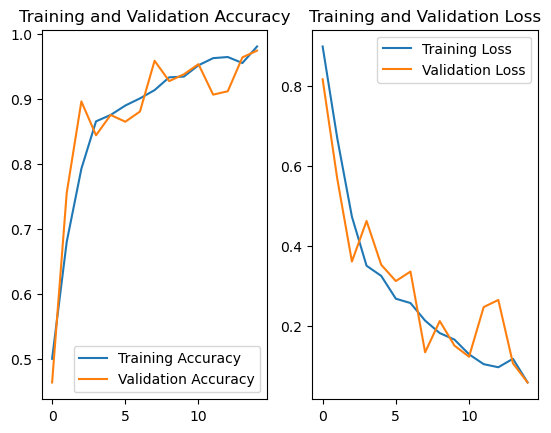

In [23]:
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

1/1 [==============================] - 1s 715ms/step
ACTUAL CLASS: Potato___Early_blight
PREDICTED CLASS: Potato___Early_blight
IMAGE:


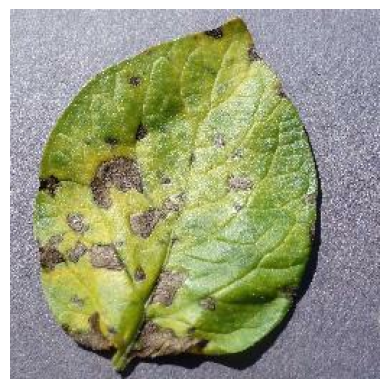

In [29]:
for image_batch, label_batch in dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    batch_prediction = model.predict(image_batch)
    
    print('ACTUAL CLASS:', class_names[first_label])
    print('PREDICTED CLASS:', class_names[np.argmax(batch_prediction[0])])
    print('IMAGE:')
    plt.imshow(first_image)
    plt.axis('off')

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)     # Expanding the dimension of the image to (1, 256, 256, 3)
    prediction = model.predict(img_array)
    confidence = round(100 * np.max(prediction[0]), ndigits=2)
    class_name = class_names[np.argmax(prediction[0])]
    
    return class_name, confidence

1/1 [==============================] - 0s 109ms/step


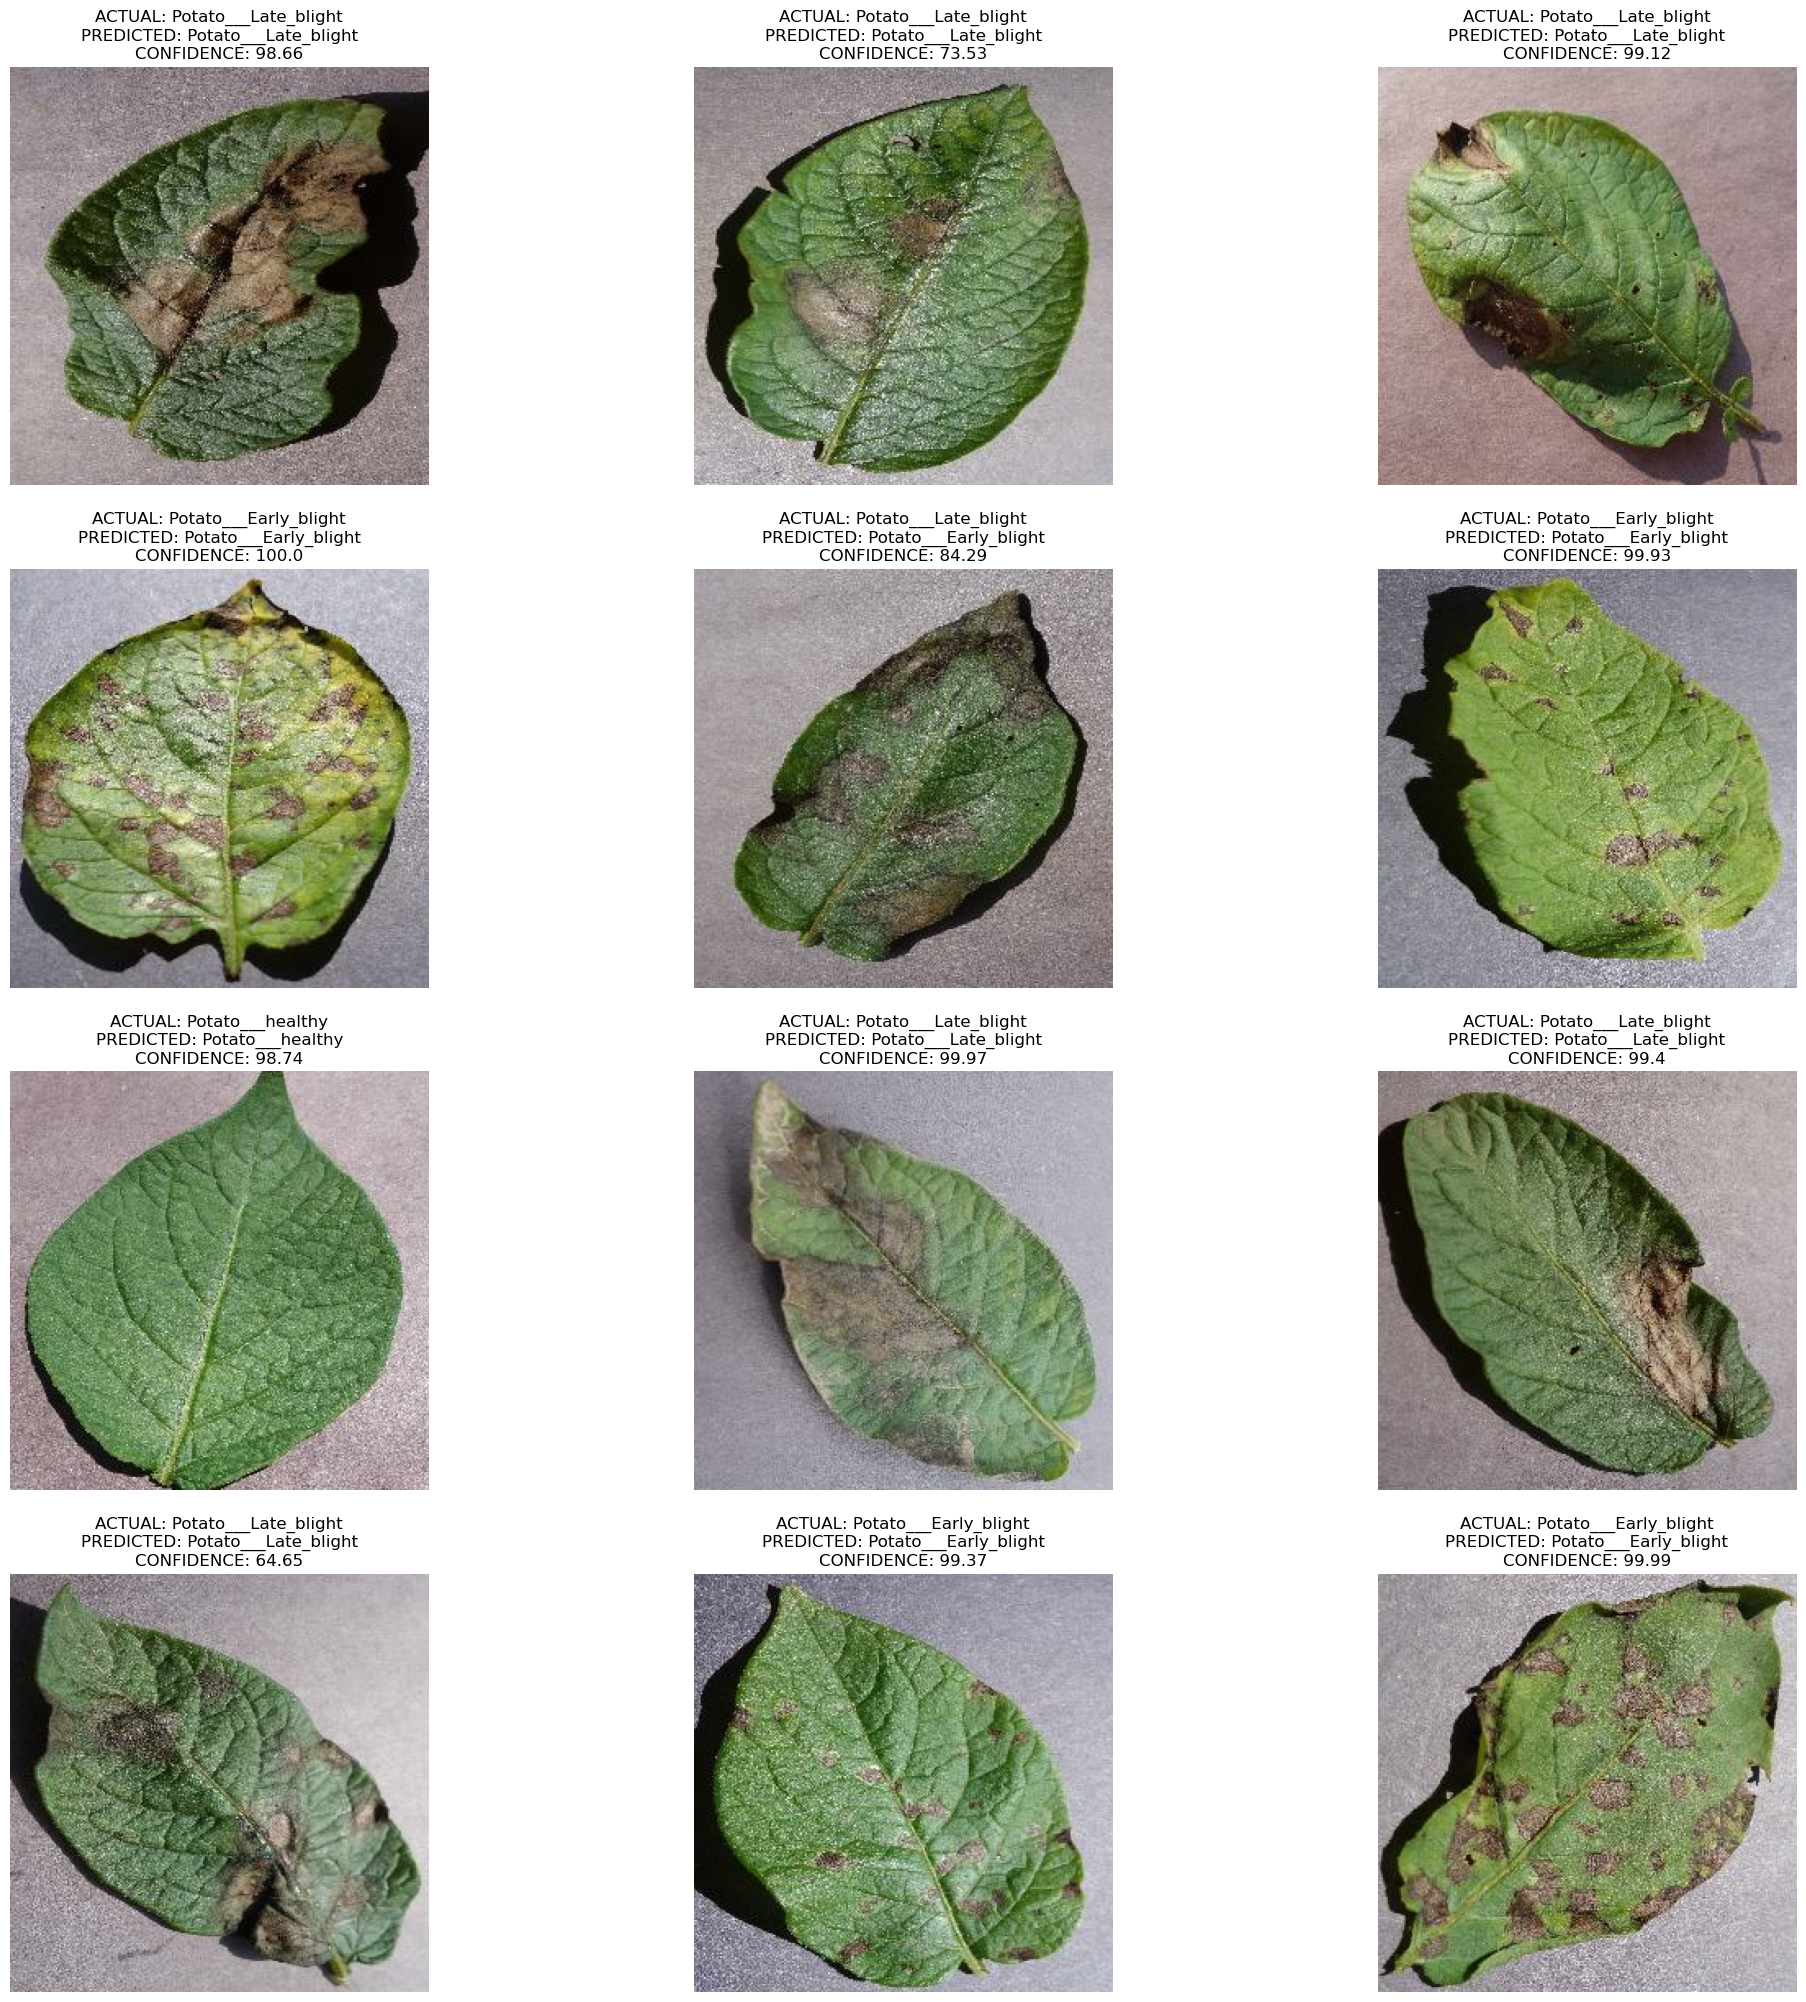

In [46]:
plt.figure(figsize=(25,25))
for image_batch, label_batch in dev_df.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        actual_class = class_names[label_batch[i].numpy()]
        predicted_class, confidence = predict(model, image_batch[i])
        
        plt.title(f'ACTUAL: {actual_class}\nPREDICTED: {predicted_class}\nCONFIDENCE: {confidence}')
        plt.axis('off')

In [74]:
import os
model_list = os.listdir('./Models/')
if len(model_list)==0:
    version=1
else:
    version = max([int(model_name.split('_')[1]) for model_name in model_list]) + 1
    
print('CURRENT MODEL VERSION:', version)

CURRENT MODEL VERSION: 1


In [75]:
model.save(f'./Models/model_{version}')

INFO:tensorflow:Assets written to: ./Models/model_1\assets


INFO:tensorflow:Assets written to: ./Models/model_1\assets
